## Gradient boosting from scratch
### Medium post with explaination: https://medium.com/@pgrover3/gradient-boosting-from-scratch-1e317ae4587d


The logic of **gradient boosting** is very simple (if explained intuitively, without using mathematical notation). I expect that whoever is reading this would have done simple linear regression modeling.
One of the very basic assumption of linear regression is that it's sum of residuals is 0. Although, tree based models are not based on any of such assumptions, but if we think logic (not statistics) behind these assumptions, we might argue that, if sum of residuals is not 0, then most probably there is some pattern in the residuals of our model which can be leveraged to make our model better.
So, the intuition behind gradient boosting algorithm is to `leverage the pattern in residuals and strenghten a weak prediction model, until our residuals become randomly (maybe random normal too) distributed`. Once we reach a stage that residuals do not have any pattern that could be modeled, we can stop modeling residuals (otherwise it might lead to overfitting). Algorithmically, we are minimizing our loss function, such that test loss reach it’s minima.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics

In [2]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

## Data simulation

In [3]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

In [4]:
# just random uniform distributions in differnt range

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

## Scatter plot of data

In [5]:
x.shape, y.shape

((50, 1), (50, 1))

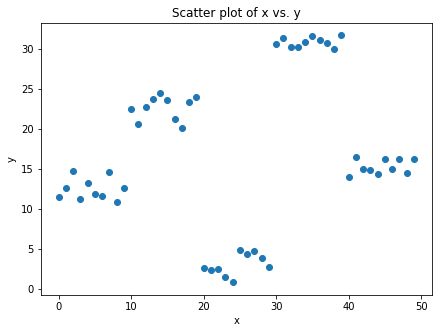

In [6]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Gradient Boosting (DecisionTrees in a loop)


In [7]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

/Users/abhishek.rathore/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


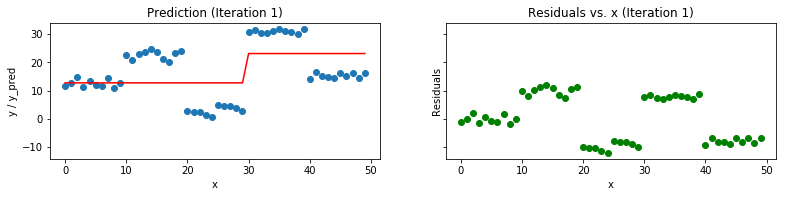

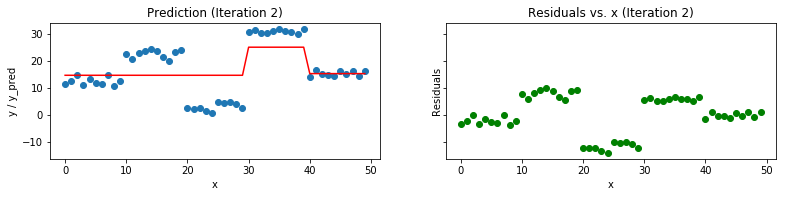

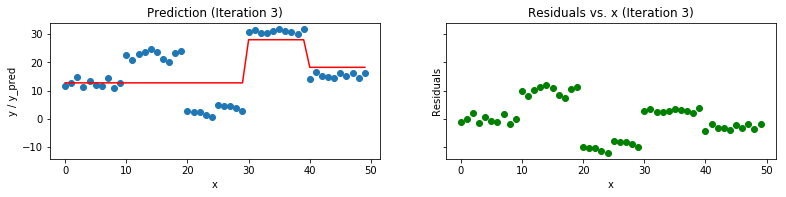

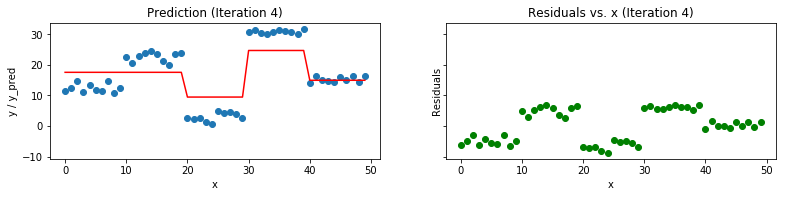

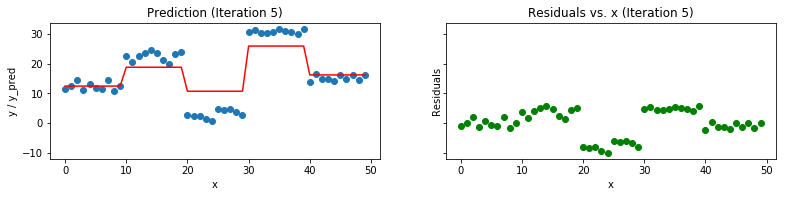

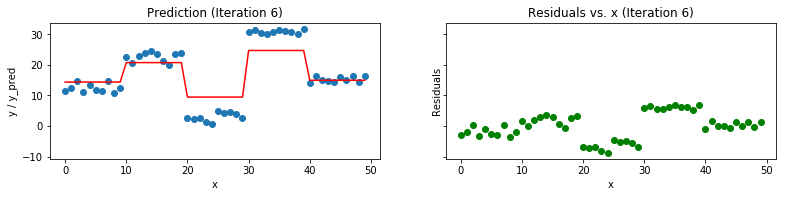

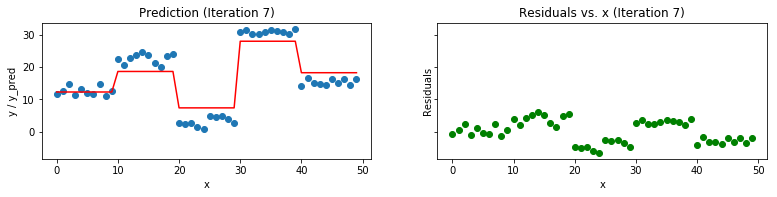

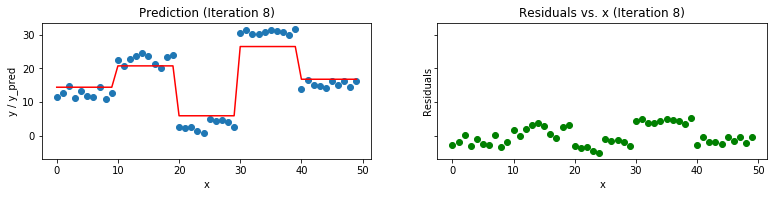

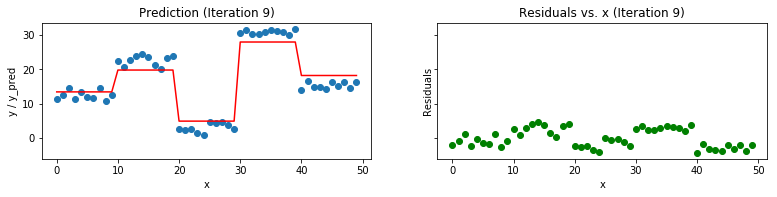

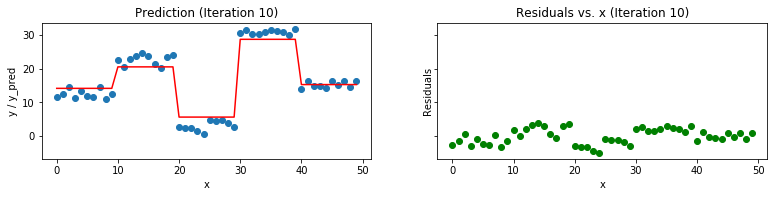

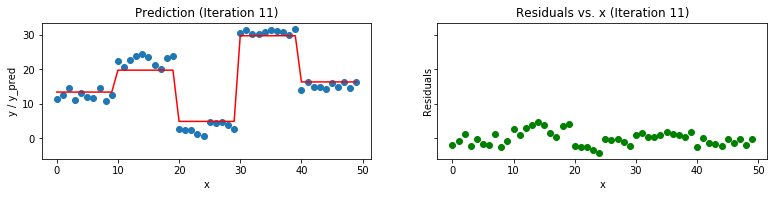

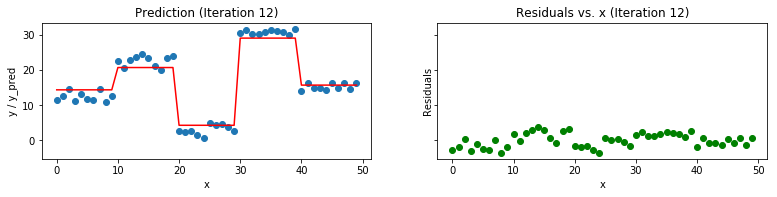

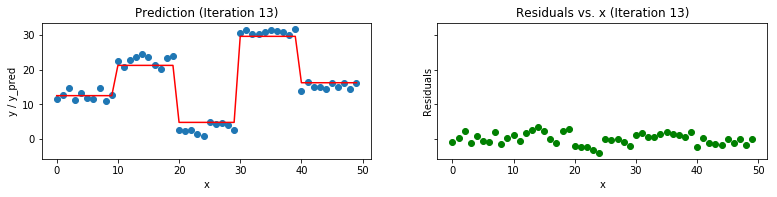

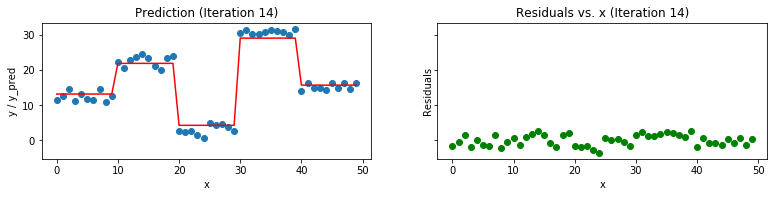

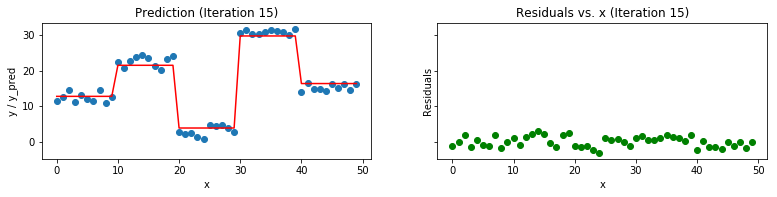

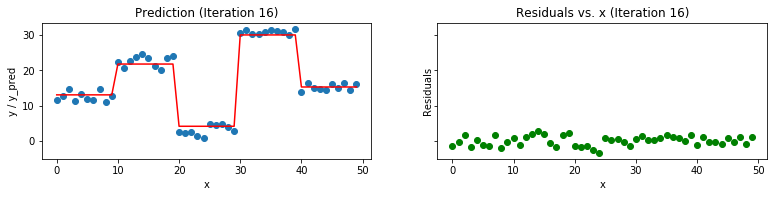

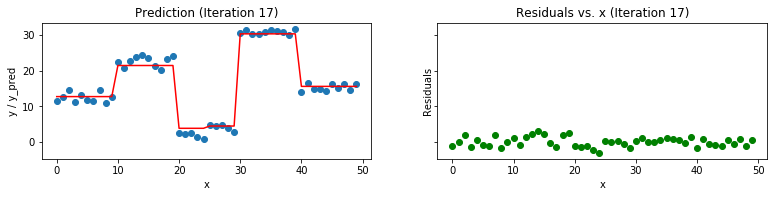

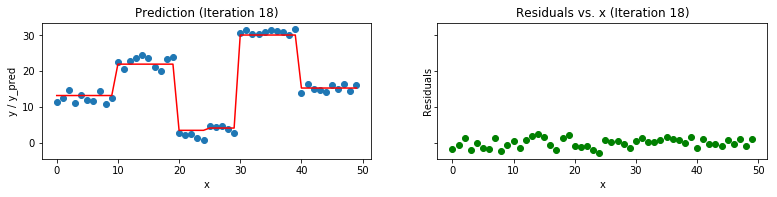

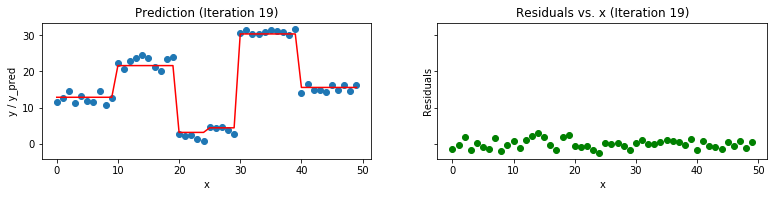

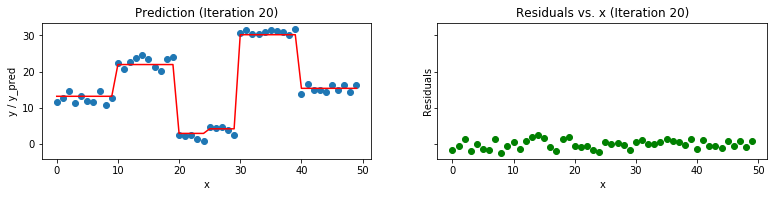

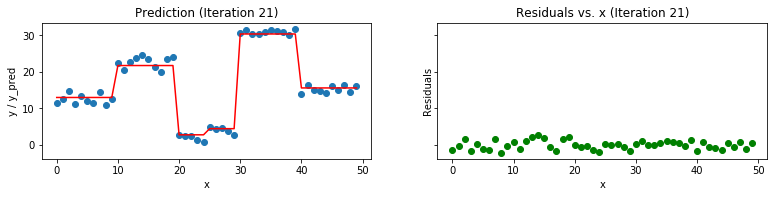

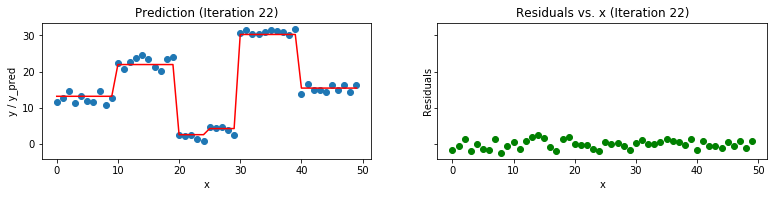

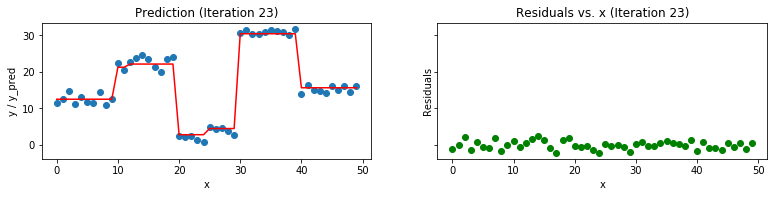

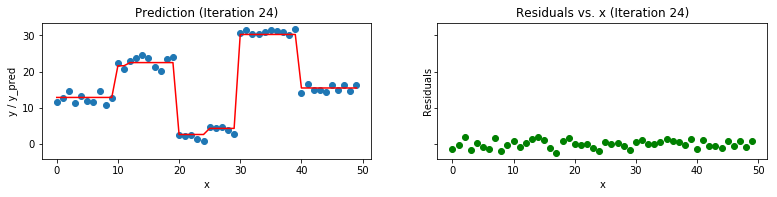

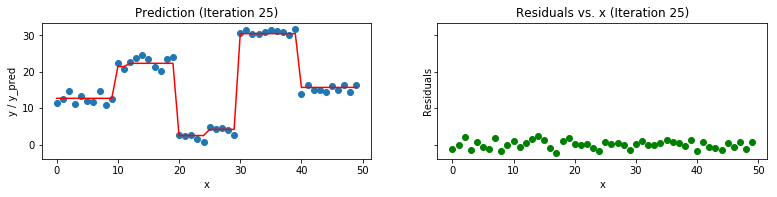

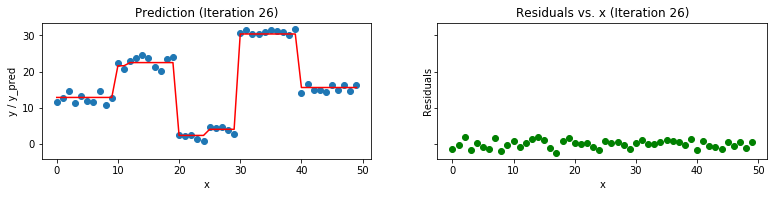

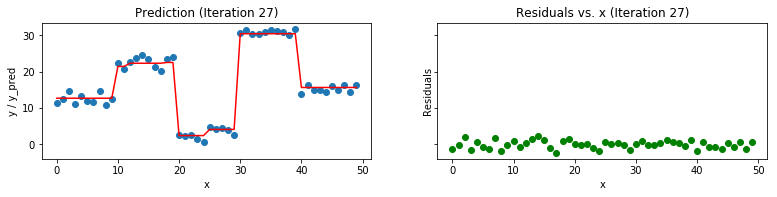

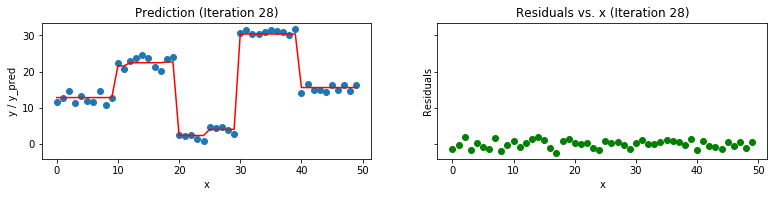

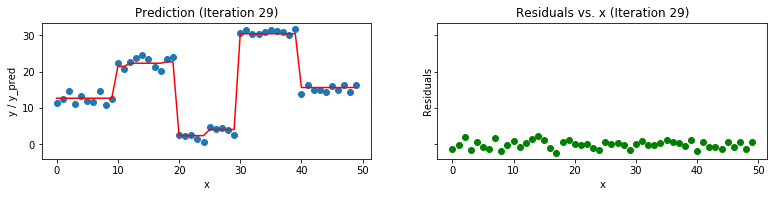

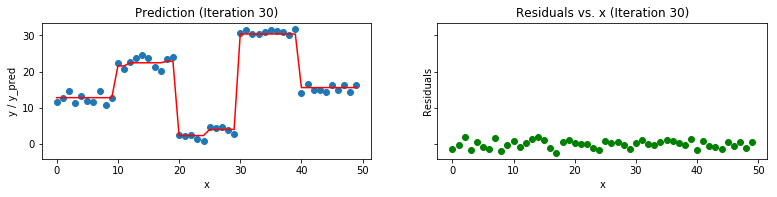

In [8]:
xi = x # initialization of input
yi = y # initialization of target
# x,y --> use where no need to change original y
ei = 0 # initialization of error
n = len(yi)  # number of rows
predf = 0 # initial prediction 0

for i in range(30): # like n_estimators
    tree = DecisionTree(xi,yi)
    tree.find_better_split(0)
    
    r = np.where(xi == tree.split)[0][0]    
    
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # make long vector (nx1) in compatible with y
    predf = predf + predi  # final prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    
    
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

    ax1.plot(x,y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title(f'Prediction (Iteration {i+1})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')
    
    

Errors are not changing much after `20th iteration` and pattern in residuals is also removed. Residuals look distributed around the mean

### Maths behind this logic

$ Predictions = y_i^p $  
$ Loss = L(y_i, y_i^p) $  
$ Loss = MSE = \sum {(y_i - y_i^p)}^2 $  
$ y_i^p = y_i^p + \alpha * \delta {L(y_i, y_i^p)}/ \delta{y_i^p } $  
$ y_i^p = y_i^p + \alpha * \delta {\sum {(y_i - y_i^p)}^2}/ \delta{y_i^p } $  
$ y_i^p = y_i^p - \alpha * 2*{\sum {(y_i - y_i^p)}} $  

where, $y_i$ = ith target value, $y_i^p$ = ith prediction, $ L(y_i, y_i^p) $ is Loss function, $\alpha$ is learning rate. So the last equation tells us that, we need to adjust predictions based on our residuals, i.e. $\sum {(y_i - y_i^p)}$. This is what we did, we adjusted our predictions using the fit on residuals. (accordingly adjusting value of $\alpha$